# Grade: /100 pts

# Assignment 04: Confidence Intervals & The Bootstrap

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [2]:
# Add the necessary imports for this homework 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from scipy.stats import t

### Question 1: /10pts 
In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.  

The $100(1-\alpha)\%$ confidence interval is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html


In [3]:
def confidence_interval(data):

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternaively, you can use scipy.stats.sem to compute
    #The standard error
    
    estimated_mean = np.mean(data)
    standard_error = np.std(data, ddof=1) / np.sqrt(len(data))
    t_value = t.ppf(0.975, len(data) - 1)
    lower_bound = estimated_mean - t_value * standard_error
    upper_bound = estimated_mean + t_value * standard_error
    bounds = np.array([lower_bound, upper_bound])
    
    return estimated_mean, bounds


### Question 2: /15pts

The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.

Write a function called `ci_simulation` that runs some simulations to show this is the case.  From a standard normal distribution, sample 25 observations and construct a confidence interval.  Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`.  Color the bar red if the confidence interval does not capture the true mean and blue if it does.  If you are unfamilliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage.

If you are unfamilliar with how to sample random numbers, I suggest you look at `numpy.random.normal`.  Try searching for the documentation for that function yourself if you need to.

Here is the documentation for `matplotlib.pyplot.errorbar`: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

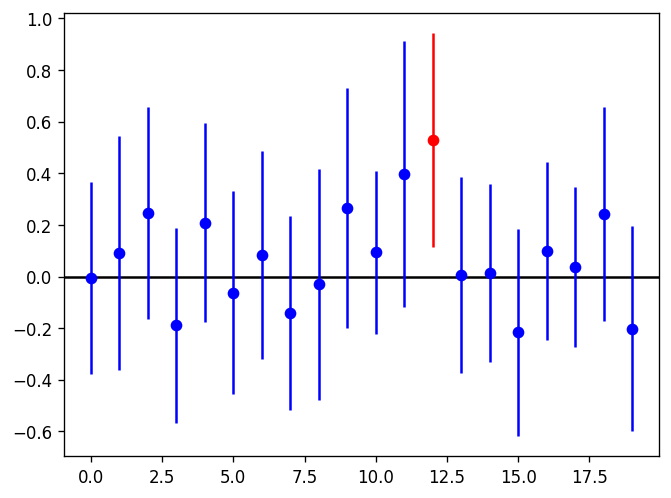

In [4]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        data = np.random.normal(size=25)

        # Compute what we need for the CI, namely the mean and the bounds
        mu, bounds = confidence_interval(data)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])
        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()

### Question 3: /8pts

If you haven't changed the random seed from 4 and if you implemented the solution correctly, you should see one red interval.

Answer the following below in no more than 3 sentences:

a) How many red intervals did we expect to see?  What is your justifiation for this?

Changing the random seed might affect how many red intervals you see.  Try changing the  random seed in your function to 3.  This will yield two red intervals (which is different than what you should expect to see). 

b) Why does the simulation sometimes deviate from the predicted results?


a **Answer**) With 20 samples, we expect to see 1 red interval. This is because out confidence interval of 95% assumes that 95% of the intervals will contain the true mean. For example if we have 100 samples, 5 should be red. Since we have 20 samples, it is 1/5 of the total number of intervals so we would expect 1/5 x 5 = 1 interval to be red. 

b **Answer**) The simulation sometimes deviates from the predicted results because the sample mean is not always equal to the true mean. The confidence interval is a range of values that is likely to contain the true population mean, but it is not guaranteed to contain it. Therefore, it is possible to observe more or fewer red intervals than expected.

### Question 4: /10pts

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their rank, weight (wt - in pounds) and height (ht - in inches). 

Fit a linear model of weight (`wt`) explained by height (`ht`) using a linear regression model from sklearn, as done in the lab (but with linear fit instead of cubic.)  Call your fitted model `model`.  
Make a scatter plot of the height (x-axis) against weight (y-axis). 
Add the predicted values for 66-80 inches. 

Calculate the residuals from the fit, and report the r-squared for this model.

Training R-squared is  0.43807746842392215


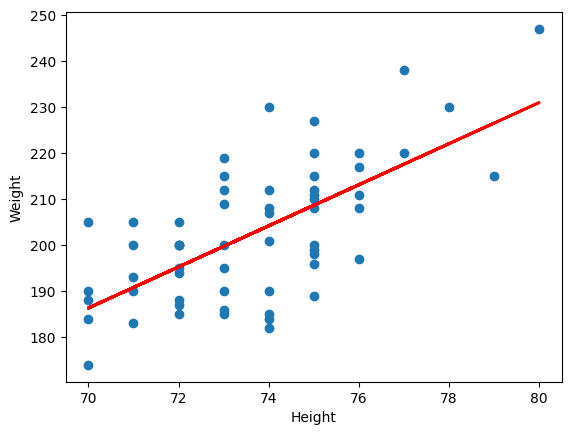

In [20]:
df=pd.read_csv('hockey_draftees_2005.csv')

# Make linear regression object and fit the model 
model = sklearn.linear_model.LinearRegression()
model.fit(df['ht'].values.reshape(-1,1), df['wt'].values)

# Make the scatter plot 
plt.scatter(df['ht'], df['wt'])
plt.xlabel('Height')
plt.ylabel('Weight')


#Generate and plot the predicted values
y_pred = model.predict(df['ht'].values.reshape(-1,1))
plt.plot(df['ht'], y_pred, color='red', linewidth=2)

# Calculate residuals, R2 and print it  

r_squared = model.score(df['ht'].values.reshape(-1,1), df['wt'].values)
print('Training R-squared is ', r_squared)


### Question 5:  /15pts
### Bootstrap confidence intervals on parameters

How confident can we be about the relation between height and weight? 
To judge this we need confidence intervals. Let's use the bootstrap.

Modify the function `BootstrapCoef` from lab 04 - part 2 to conduct a boostrap analysis for this regression mode; 

* `data`, which is a dataframe having columns 'weight' and 'height'
* `numboot` which is an integer denoting how many bootstrap replications to perform.

Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  `bootstrap` should return:
params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept value and the slope from the linear regression. 
Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_. 

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Then call the function to get 100 bootstrap samples for your linear regression model of wt explained by height. 
Make a joint scatter plot of the parameter value for the intercept and for the slope. 

In [15]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data, numboot=1000):
    n = len(data)
    params = np.zeros((numboot, 2)) 
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = d['ht'].values.reshape(-1, 1)
        y_fit = d['wt'].values
        model.fit(X_fit, y_fit)
        params[i, 0] = model.intercept_  # Store intercept
        params[i, 1] = model.coef_[0]  # Store slope
    
    return params

thetaBS = BootstrapCoef(df, 100)
print(thetaBS)


[[ -55.5672882     3.50459397]
 [-156.65952828    4.86816475]
 [ -95.6436838     4.07679482]
 [ -91.39832055    4.02592187]
 [-191.48823622    5.34209695]
 [-150.32067396    4.78063712]
 [-154.97612126    4.89457018]
 [-210.11521267    5.63871503]
 [-142.21371122    4.69896591]
 [-151.65629927    4.79432421]
 [-124.02395653    4.38348975]
 [-112.31788079    4.28140267]
 [-103.97079421    4.15669266]
 [ -45.72591508    3.34099561]
 [ -87.29407209    3.93206139]
 [-141.67972509    4.64621993]
 [-188.91327125    5.33003492]
 [-186.98461872    5.26018198]
 [-199.84217943    5.46477219]
 [-127.74098996    4.48420392]
 [ -93.56003666    4.02520623]
 [-172.68654875    5.09008638]
 [-156.99130631    4.87298182]
 [ -74.79850078    3.73450436]
 [-200.9788667     5.4655713 ]
 [-183.52194357    5.2460815 ]
 [ -70.60952381    3.7352381 ]
 [ -80.93647903    3.87092914]
 [-135.03784727    4.57797611]
 [ -87.09136075    3.93513663]
 [-166.87485311    5.02996475]
 [-106.22448161    4.18113712]
 [ -93.7

AttributeError: PathCollection.set() got an unexpected keyword argument 'xlabel'

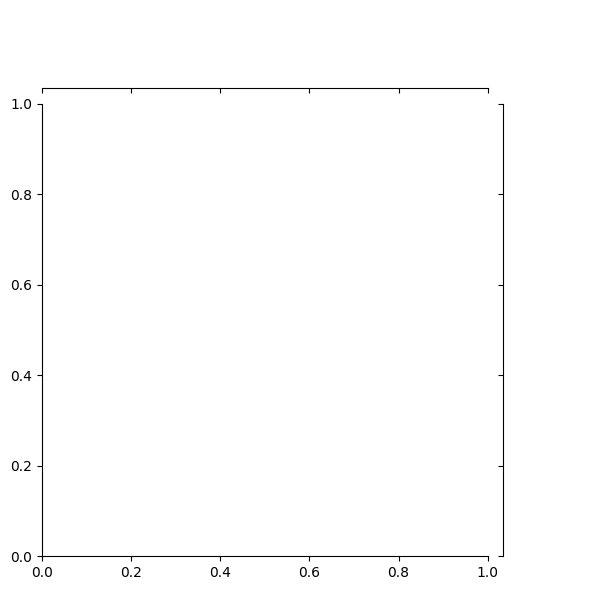

In [27]:
# Make scatter plot
sns.jointplot(x=thetaBS[:,0], y=thetaBS[:,1], 
              xlabel='Intercept', 
              ylabel='Slope')

### Question 6: /12pts

Plot the bootstrap estimates for the slope as a histogram.  Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the slope. How can you interpret this confindence interval?  

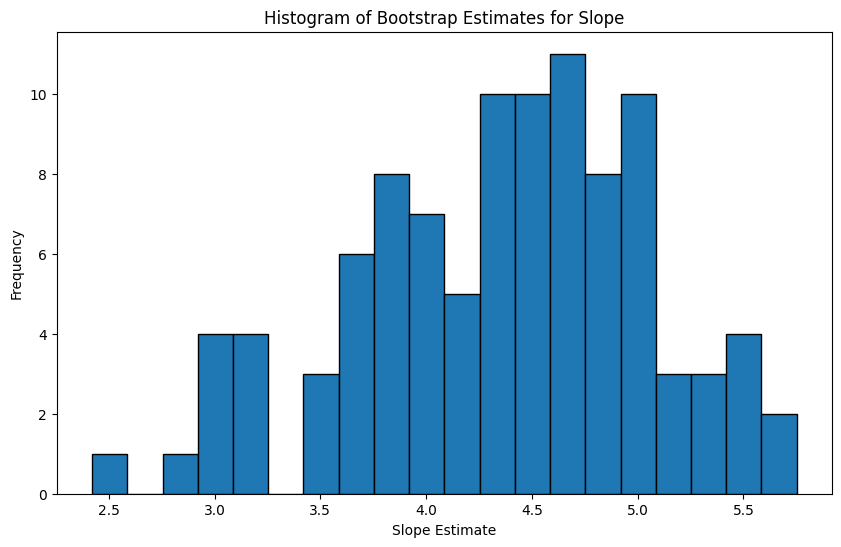

My confidence interval is between 4.223119094843931  and  4.498767475342359


In [14]:
plt.figure(figsize=(10, 6))
plt.hist(thetaBS[:, 1], bins=20, edgecolor='black')
plt.title('Histogram of Bootstrap Estimates for Slope')
plt.xlabel('Slope Estimate')
plt.ylabel('Frequency')
plt.show()
# Calculate bootstrap interval
boot_ci = confidence_interval(thetaBS[:,1])[1]


print('My confidence interval is between', boot_ci[0], ' and ', boot_ci[1])

Written answer: The interval contains the true slope parameter with a probability of 95%. 

### Question 7: /15pts
Modify the function `BootstrapPred` from lab04 to bootstrap your fit and generate a predict from each of these bootstrapped models.  

Draw again a scatter plot of ht against weight. and plot the predictions from the 20 fitted bootstrap models to derive predictions for the height ranging from 66 to 80. Draw all these lines onto your scatter plot. 

Written question: Where are we most uncertain in our prediction about the weight of a player? How does the negative correlation between slope and intercept play a role here?  Why is the spread of the prediction in the mean weight so much lower than the variability of our intercept parameter? 

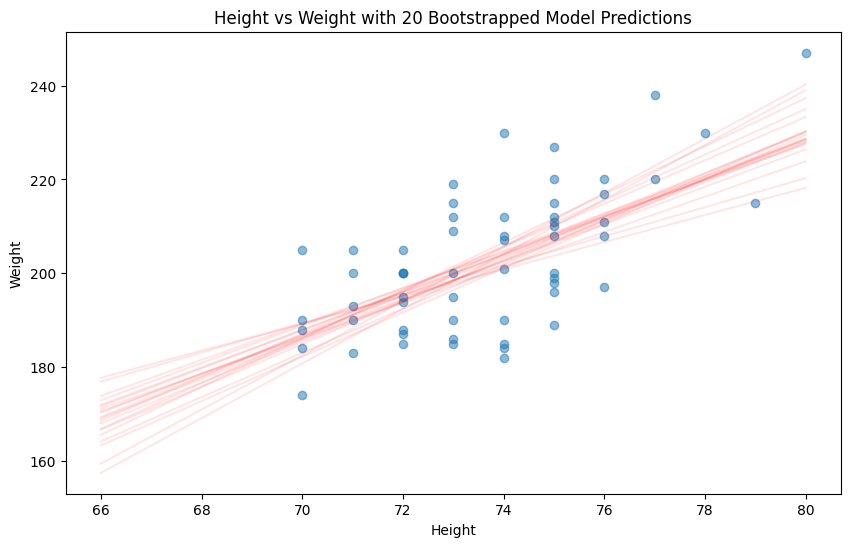

In [18]:
# Write a Bootstrap function that records the fitted models 
def BootstrapPred(data, xp):
    numboot = 20 
    n = len(data)
    X_pred = xp.reshape(-1, 1)
    y_pred = np.zeros((numboot, X_pred.shape[0]))    

    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_fit = d['ht'].values.reshape(-1, 1)
        y_fit = d['wt'].values
        model.fit(X_fit, y_fit)
        y_pred[i,:] = model.predict(X_pred)
    return y_pred

# Get predictions from 20 bootstrapped models 
heights = np.linspace(66, 80, 100)  # Generate heights from 66 to 80
predictions = BootstrapPred(df, heights)

# Make a scatterplot and draw the 20 lines  
plt.figure(figsize=(10, 6))
plt.scatter(df['ht'], df['wt'], alpha=0.5)
for i in range(20):
    plt.plot(heights, predictions[i], color='r', alpha=0.1)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight with 20 Bootstrapped Model Predictions')
plt.show()


**Written Answer Here**

### Question 8:  /15pts

Now, let's see how well our model performs out of sample.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions. 

Make a scatter plot of the test data and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-squared value for the out of sample (oos) data.  Statsmodels doesn't provide a function to compute r-squared on new data.  You will have to write one yourself or find one that performs the computation for you.

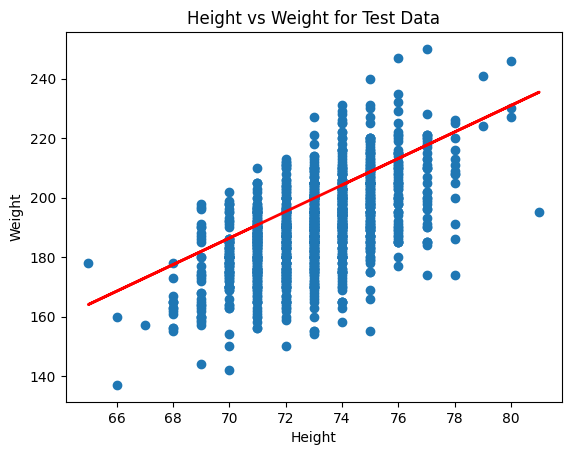

Out of sample rsquared is  -0.015001136144206173


In [24]:
df_test=pd.read_csv('hockey_draftees_test.csv')

# Make the scatter plot 
plt.scatter(df_test['ht'], df_test['wt'])
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight for Test Data')

# Generate and plot the predicted values
y_pred_test = model.predict(df_test['ht'].values.reshape(-1,1))
plt.plot(df_test['ht'], y_pred_test, color='red', linewidth=2)
plt.show()

# Now do the prediction for the test data and compute R2
rsquared_oos = model.score(df_test['ht'].values.reshape(-1,1), df_test['wt'].values)

print('Out of sample rsquared is ', rsquared_oos)